# Cryptonians #
_**Project Group 2**_

---
## Contents

1. [Data](#Data)  

   1.1 [Load](#Load)  
   
   1.2 [Overview](#Overview)
   
   1.3 [Transformation](#Transformation) 
   
         1.3.1  [Entire Time Series Summaries, Aggregated by Day](#13df_daily)
         
         1.3.2  [Percentage Changes, Aggregated by Day](#13df_deltas)
         
         1.3.3  [Rolling Averages and Standard Deviations, Aggregated by Day](#13df_rolling)
         
   1.4 [Feature Exploration](#Overview)
   
   
2. [Training](#Training)

   2.1 [RCF modelling with the df_daily datraframe](#21df_daily)
   
   2.2 [RCF modelling with the df_deltas datraframe](#22df_deltas)
   
   2.2 [RCF modelling with the df_rolling datraframe](#23df_rolling)
   
   
3. [Summary](#Summary)



# 1. Data  
Place holder for description



## 1.1  Load
Place holder for description

In [51]:
import boto3
import botocore
import sagemaker
from sagemaker import RandomCutForest
from sagemaker.predictor import csv_serializer, json_deserializer
import sys
import pandas as pd
import io
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta 

# Until we figure out S3 access, we will need to change to our own S3 and prefix.
bucket = 'sagemaker-davidrob'
prefix = 'group-project/bitcoin'
# @David, please change prefix to 'minute' to save your data
# prefix = 'minute'
filename = 'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27-orig.csv'

############################## KEYS ############################
# @All, please use the accessKeys.csv sent in the email to fill the keys, make sure we don't publish note book with keys to Github.
# AWS will remove key sets from account.
access_key_id='INSERT_HERE'
secret_access_key='INSERT_HERE'
################################################################

execution_role = sagemaker.get_execution_role()

# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://sagemaker-davidrob/group-project/bitcoin


In [2]:
# Step 1.1: get the bitcoin minute-by-minute data from kaggle
# https://www.kaggle.com/mczielinski/bitcoin-historical-data#bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv

#!pip install kaggle
#!kaggle datasets download -d mczielinski/bitcoin-historical-data
#!mkdir bitcoin-historical-data
#!mv bitcoin-historical-data.zip /bitcoin-historical-data
#!unzip -a /bitcoin-historical-data/bitcoin-historical-data.zip
#df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

s3 = boto3.client('s3')
raw_data = s3.get_object(Bucket=bucket, Key=f'group-project/bitcoin/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
df = pd.read_csv(io.BytesIO(raw_data['Body'].read()), encoding="ISO-8859-1", low_memory=False)

## 1.2  Explore
Place holder for description

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


## 1.3  Transformation
Remove records with missing data.

Add time groupings to roll up by hours and days.

Create three datasets with generated features focusing on: 
* overall summary statistics, 
* various delta calculations and 
* rolling average and standard deviations


#### Remove Missing Values

In [4]:
# Remove NA
df = df.dropna(how='any')

#### Date time feature generation

In [5]:
# Step 1.3a: Add day and hour data elements to the dataframe so we can group by days and hours in later analysis

# create various date formats for grouping later on
df['Time'] = pd.to_datetime(df['Timestamp'], unit = 's', infer_datetime_format = 'True')
df['Date'] = df['Time'].values.astype('datetime64[D]')
df['Hour'] = df['Time'].values.astype('datetime64[h]')
df['Minute'] = df['Time'].values.astype('datetime64[m]')

df = df.drop(columns=['Time', 'Timestamp'])

# reality check - make sure the dataframe looks right so far.
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date,Hour,Minute
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:52:00
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:53:00
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:54:00
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:55:00
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 07:00:00,2011-12-31 07:56:00


In [6]:
df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06
mean,1.535757e+03,1.537163e+03,1.534153e+03,1.535739e+03,1.101862e+01,1.533527e+04,1.535645e+03
std,3.037551e+03,3.041014e+03,3.033519e+03,3.037511e+03,3.500616e+01,7.259934e+04,3.037272e+03
min,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.228200e+02,1.228900e+02,1.227600e+02,1.228100e+02,4.767414e-01,7.732200e+01,1.228200e+02
50%,4.167300e+02,4.168700e+02,4.165600e+02,4.167200e+02,2.157220e+00,4.738905e+02,4.167000e+02
75%,8.094000e+02,8.099700e+02,8.089900e+02,8.094800e+02,8.931947e+00,4.197468e+03,8.093700e+02
max,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


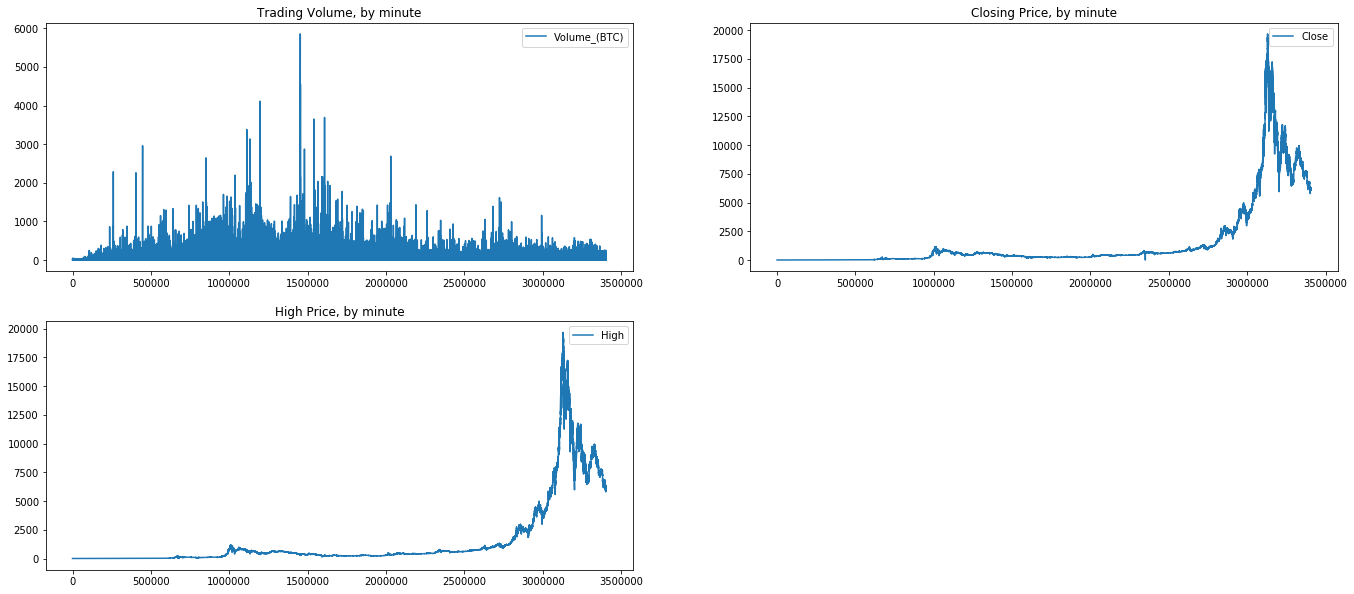

In [7]:
# Step 1.3b: Show some charts

# plot the minute-by-minute data
plt.subplot(221)
df['Volume_(BTC)'].plot(legend=True)
plt.title('Trading Volume, by minute')

plt.subplot(222)
df['Close'].plot( legend=True)
plt.title('Closing Price, by minute')

plt.subplot(223)
df['High'].plot(legend=True)
plt.title('High Price, by minute')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


### 1.3.1  Basic Aggregation and Feature Generation by Day

In [8]:
# Step 4: group minute-by-minute data points by day to view the standard deviation of the features in the array below
# df_transform = df.groupby(['Date'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price'].agg(['min', 'max', 'std','mean'])
df_daily = df.groupby(['Date'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'].agg(['min', 'max', 'std','mean'])
# removing '2018-06-27' because I know these values contain NA values and can't be used for training data.
#df_daily = df_daily[df_daily.index != '2018-06-27']

# renaming columns
df_daily.columns = ['Open_min','Open_max','Open_std','Open_mean',\
                      'High_min','High_max','High_std','High_mean', \
                      'Low_min','Low_max','Low_std','Low_mean',\
                      'Close_min','Close_max','Close_std','Close_mean',\
                      'Vol_BTC_min','Vol_BTC_max','Vol_BTC_std','Vol_BTC_mean',\
                      'Vol_Currency_min','Vol_Currency_max','Vol_Currency_std','Vol_Currency_mean',\
                      'Wt_Price_min','Wt_Price_max','Wt_Price_std','Wt_Price_mean']

# only 2,368 data elements in this dataframe
print(df_daily.shape)
# df_daily.head()

(2368, 28)


,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_BTC_std,Vol_BTC_mean,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean
count,2368.000000,2368.000000,2367.000000,2368.000000,2368.000000,2368.000000,2367.000000,2368.000000,2368.000000,2368.000000,...,2367.000000,2368.000000,2368.000000,2.368000e+03,2367.000000,2368.000000,2368.000000,2368.000000,2367.000000,2368.000000
mean,1471.343674,1594.217373,28.754174,1536.670359,1474.282580,1595.604607,28.642632,1538.075386,1469.201182,1592.239130,...,26.644910,11.042641,87.386706,4.341289e+05,29111.856419,15384.776937,1471.422947,1594.088667,28.770256,1536.556323
std,2881.854383,3175.707727,81.676950,3036.796252,2888.516571,3178.478143,81.325773,3040.268635,2878.396098,3170.709672,...,21.056891,8.887354,2944.878656,7.675410e+05,55177.050092,37228.936359,2882.112070,3175.228283,81.685035,3036.514866
min,3.800000,4.380000,0.000000,4.328903,3.800000,4.380000,0.000000,4.328903,1.500000,4.380000,...,0.236352,0.333540,0.000000,6.000000e+00,1.704544,2.057071,3.800000,4.380000,0.000000,4.328903
25%,118.295000,125.130000,0.834915,122.838089,118.407500,125.130000,0.831698,122.890481,117.760000,125.112500,...,13.708088,5.373613,0.491707,4.748237e+04,3017.089388,991.506395,118.095957,125.112804,0.838932,122.833814
50%,408.295000,422.370000,2.899077,416.363757,409.135000,422.400000,2.902781,416.494396,407.235000,422.370000,...,20.743492,8.560639,2.579456,1.401348e+05,8548.530553,2659.305155,408.774454,422.370000,2.930358,416.375524
75%,786.032500,830.175000,11.758791,811.115167,787.732500,830.350000,11.639957,811.613557,785.000000,829.640000,...,33.600570,13.988587,5.012679,3.890178e+05,21786.753492,7771.478061,785.717857,830.036817,11.762217,811.119846
max,18492.000000,19665.760000,836.715679,19189.771083,18621.810000,19666.000000,827.634032,19204.559312,18465.000000,19649.960000,...,341.879912,104.504766,142706.803850,5.483271e+06,505925.178970,536217.694927,18495.292527,19663.298888,835.459423,19186.169610


In [107]:
df_daily = df_daily.dropna(how='any')
df_daily.head()

,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_BTC_std,Vol_BTC_mean,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,4.39,4.58,0.094181,4.472552,4.39,4.58,0.094229,4.472624,4.39,4.58,...,11.978798,7.590527,2.00000,210.720000,52.694724,34.069690,4.39,4.580000,0.094193,4.472579
2012-01-01,4.58,5.00,0.139856,4.680778,4.58,5.00,0.139856,4.680778,4.58,5.00,...,4.094532,5.861697,6.87916,50.500000,19.802958,27.856539,4.58,5.000000,0.139856,4.680778
2012-01-02,5.00,5.00,0.000000,5.000000,5.00,5.00,0.000000,5.000000,5.00,5.00,...,3.313474,11.566478,50.50000,95.240000,16.567370,57.832389,5.00,5.000000,0.000000,5.000000
2012-01-03,5.00,5.32,0.145733,5.145917,5.00,5.32,0.145733,5.145917,5.00,5.32,...,9.048262,13.506125,0.10280,155.010000,46.211054,68.725391,5.00,5.320000,0.145733,5.145917
2012-01-04,4.93,5.37,0.189487,5.176708,4.93,5.57,0.252133,5.228729,4.93,5.37,...,15.589931,17.221039,0.99000,235.747069,85.932931,91.624089,4.93,5.442972,0.210158,5.195443


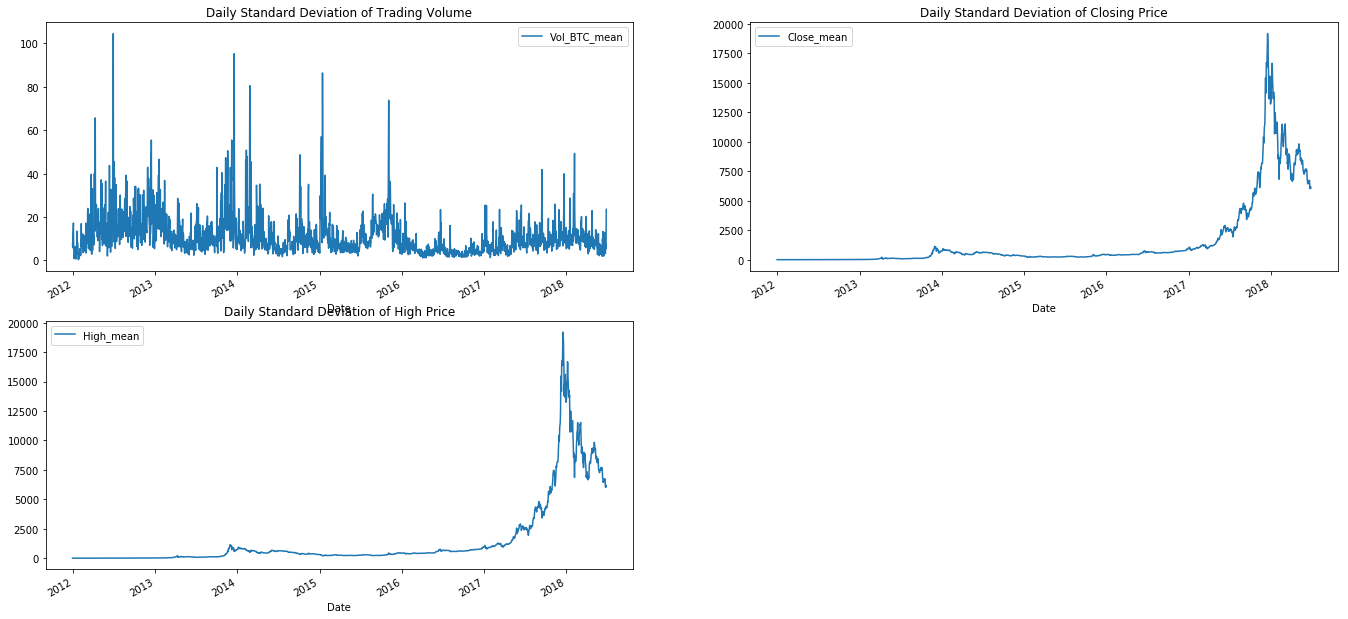

In [10]:
# Step 1.3.1: same charts using the standard deviation data when minute-level daata is grouped by day
# plotting the daily volatility measures
plt.subplot(221)
df_daily['Vol_BTC_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of Trading Volume')

plt.subplot(222)
df_daily['Close_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of Closing Price')

plt.subplot(223)
df_daily['High_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of High Price')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


### 1.3.2  Percentage Changes, Aggregated by Day

In [108]:
# 1.3.2
#create features based on the percentage difference between minute-level values and the corresponding values in the precending minute,
#30 minutes prior and 60 minutes prior.
df_deltas = df.copy()
# filter Volume values. There are some values in this data set that are very close to zero.
# when we perform percent change calculations on those values, we calculate extremely large values that overwhelm the anomaly scores.
df_deltas = df_deltas[df_deltas['Volume_(BTC)'] > 1] 
df_deltas[['Open_delta_1', 'High_delta_1', 'Low_delta_1', 'Close_delta_1', 'Volume_(BTC)_delta_1', 'Weighted_Price_delta_1']] = df_deltas[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 1)
df_deltas[['Open_delta_30', 'High_delta_30', 'Low_delta_30', 'Close_delta_30', 'Volume_(BTC)_delta_30', 'Weighted_Price_delta_30']] = df_deltas[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 30)
df_deltas[['Open_delta_60', 'High_delta_60', 'Low_delta_60', 'Close_delta_60', 'Volume_(BTC)_delta_60', 'Weighted_Price_delta_60']] = df_deltas[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 60)

#removes the columns that were used to form the percentage delta features from  df_deltas
#this data will be used again beginning with step 16
df_deltas = df_deltas[df_deltas.columns.difference(["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)", "Weighted_Price"])]
df_deltas = df_deltas.dropna(how='any')
df_deltas.head()

,Close_delta_1,Close_delta_30,Close_delta_60,Date,High_delta_1,High_delta_30,High_delta_60,Hour,Low_delta_1,Low_delta_30,...,Minute,Open_delta_1,Open_delta_30,Open_delta_60,Volume_(BTC)_delta_1,Volume_(BTC)_delta_30,Volume_(BTC)_delta_60,Weighted_Price_delta_1,Weighted_Price_delta_30,Weighted_Price_delta_60
538,0.0,0.0,0.0,2011-12-31,0.0,0.0,0.0,2011-12-31 16:00:00,0.0,0.0,...,2011-12-31 16:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539,0.0,0.0,0.0,2011-12-31,0.0,0.0,0.0,2011-12-31 16:00:00,0.0,0.0,...,2011-12-31 16:51:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540,0.0,0.0,0.0,2011-12-31,0.0,0.0,0.0,2011-12-31 16:00:00,0.0,0.0,...,2011-12-31 16:52:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541,0.0,0.0,0.0,2011-12-31,0.0,0.0,0.0,2011-12-31 16:00:00,0.0,0.0,...,2011-12-31 16:53:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542,0.0,0.0,0.0,2011-12-31,0.0,0.0,0.0,2011-12-31 16:00:00,0.0,0.0,...,2011-12-31 16:54:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
df_deltas.describe()

,Close_delta_1,Close_delta_30,Close_delta_60,High_delta_1,High_delta_30,High_delta_60,Low_delta_1,Low_delta_30,Low_delta_60,Open_delta_1,Open_delta_30,Open_delta_60,Volume_(BTC)_delta_1,Volume_(BTC)_delta_30,Volume_(BTC)_delta_60,Weighted_Price_delta_1,Weighted_Price_delta_30,Weighted_Price_delta_60
count,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06,2.161736e+06
mean,1.865234e-04,3.443423e-04,4.929523e-04,6.377057e-06,1.640010e-04,3.114731e-04,1.867229e-04,3.458020e-04,4.952715e-04,6.641126e-06,1.646143e-04,3.130332e-04,1.346527e+00,2.616673e+00,2.802988e+00,6.246279e-06,1.653654e-04,3.140199e-04
std,2.641646e-01,2.627881e-01,2.628546e-01,2.476904e-03,1.134236e-02,1.477841e-02,2.641654e-01,2.625673e-01,2.626011e-01,2.573390e-03,1.137938e-02,1.487090e-02,8.590447e+00,1.382810e+01,1.398575e+01,2.414571e-03,1.144771e-02,1.494014e-02
min,-9.974514e-01,-9.974535e-01,-9.974576e-01,-3.890675e-01,-4.909091e-01,-6.060302e-01,-9.974434e-01,-9.974534e-01,-9.974576e-01,-3.841167e-01,-4.909091e-01,-6.060302e-01,-9.990198e-01,-9.997319e-01,-9.997077e-01,-3.869810e-01,-4.856467e-01,-6.062385e-01
25%,-7.410441e-05,-2.703383e-03,-3.869658e-03,-4.293688e-05,-2.612046e-03,-3.809218e-03,-3.011957e-05,-2.645318e-03,-3.824255e-03,-7.874016e-05,-2.596285e-03,-3.777768e-03,-3.133335e-01,-5.975598e-01,-6.249318e-01,-1.590298e-04,-2.655304e-03,-3.838887e-03
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.044160e-04,3.214599e-03,4.676374e-03,2.226202e-05,3.029745e-03,4.516129e-03,1.023911e-04,3.249189e-03,4.731997e-03,1.121779e-04,3.094430e-03,4.575311e-03,4.348155e-01,1.469517e+00,1.646889e+00,2.097437e-04,3.164649e-03,4.649226e-03
max,3.883733e+02,3.860000e+02,3.858400e+02,5.763158e-01,9.113924e-01,6.756757e-01,3.883733e+02,3.856667e+02,3.854533e+02,5.763158e-01,9.260204e-01,6.756757e-01,1.670984e+03,3.496064e+03,2.623425e+03,5.763158e-01,8.976979e-01,6.242447e-01


### 1.3.3 30-Day Rolling Averages and Rolling Standard Deviations

In [110]:
# 1.3.3
df_rolling = df.copy()
df_rolling = df_rolling.groupby(by=['Date'], as_index=True).agg({'Open':'first',
                                                                 'Low': 'min', 
                                                                 'Weighted_Price':'mean', 
                                                                 'High': 'max', 
                                                                 'Close':'last',
                                                                 'Volume_(BTC)' : 'sum', 
                                                                 'Volume_(Currency)' : 'sum'})

df_rolling['Price30DayRollMean'] = df_rolling['Weighted_Price'].rolling(30).mean()
df_rolling['PriceMinus30DayRollMean'] = df_rolling['Weighted_Price']-df_rolling['Weighted_Price'].rolling(30).mean()
df_rolling['PriceIntraDayDelta'] =  df_rolling['High'] - df_rolling['Low']

df_rolling['Volume30DayRollMean'] = df_rolling['Volume_(BTC)'].rolling(30).mean()
df_rolling['VolumeMinus30DayRollMean'] = df_rolling['Volume_(BTC)']-df_rolling['Volume_(BTC)'].rolling(30).mean()

df_rolling['Price30DayRollStDev'] = df_rolling['Weighted_Price'].rolling(30).std()
df_rolling['Volume30DayRollStDev'] = df_rolling['Volume_(BTC)'].rolling(30).std()

df_rolling = df_rolling.drop(columns=['Open','Close','High','Low'], axis=1)

#drop the first 30 records because they won't have data to calculate the largest-window moving average & standard deviation
df_rolling.drop(df_rolling.index[:30], inplace=True)

# reality check - make sure the dataframe looks right so far.
df_rolling = df_rolling.dropna(how='any')
df_rolling.head()

,Weighted_Price,Volume_(BTC),Volume_(Currency),Price30DayRollMean,PriceMinus30DayRollMean,PriceIntraDayDelta,Volume30DayRollMean,VolumeMinus30DayRollMean,Price30DayRollStDev,Volume30DayRollStDev
Date,,,,,,,,,,
2012-01-30,5.505306,5244.584086,28848.555197,6.256003,-0.750697,0.28,7234.994949,-1990.410863,0.675722,6472.951698
2012-01-31,5.603342,4177.518504,24135.933834,6.286755,-0.683413,2.42,7092.884099,-2915.365595,0.620280,6492.335620
2012-02-01,5.562427,3419.889674,19882.109092,6.305502,-0.743075,0.69,6651.689488,-3231.799814,0.587691,6265.850402
2012-02-02,6.100355,7791.757570,47026.289643,6.337317,-0.236962,0.40,6263.120747,1528.636823,0.547191,5788.124577
2012-02-03,6.200014,6254.011518,38324.490716,6.370803,-0.170789,0.42,5644.977922,609.033596,0.503931,4610.907354


<Figure size 720x432 with 0 Axes>

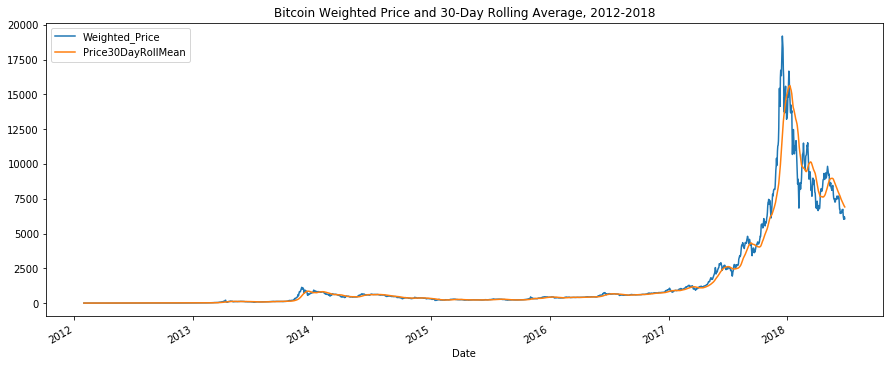

In [111]:
# Step 1.3.3b: df_rolling summaary charts

# Plotting price vs 30-day rolling average of price

plt.figure(figsize=(10,6), facecolor='white')
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15,6))

df_rolling['Weighted_Price'].plot(legend=True)
df_rolling['Price30DayRollMean'].plot(legend=True)
axis.set_title("Bitcoin Weighted Price and 30-Day Rolling Average, 2012-2018")

plt.savefig('price_and_rolling_average.png', bbox_inches='tight')

<Figure size 720x2880 with 0 Axes>

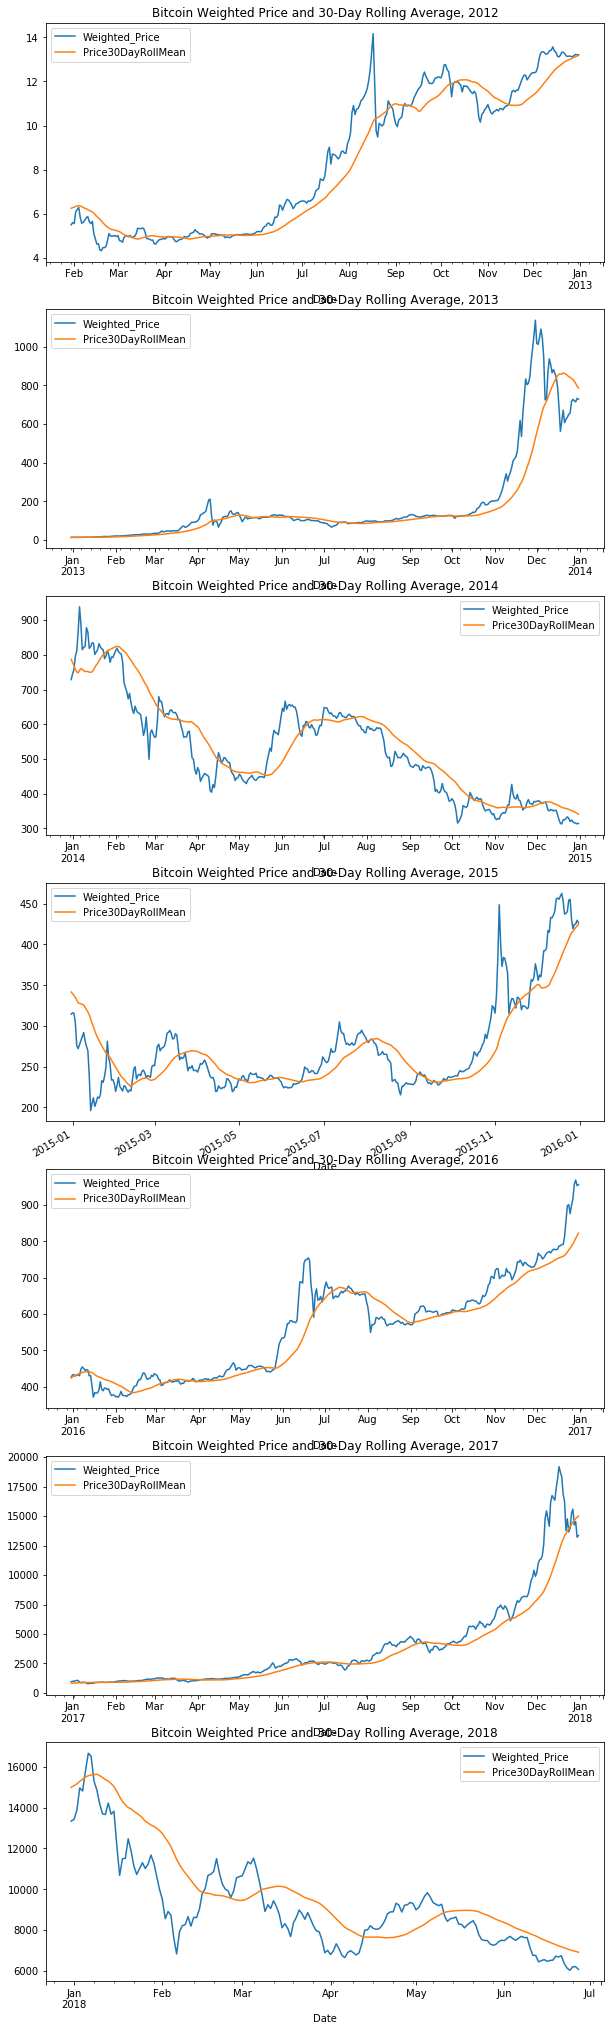

In [112]:
# Step 1.3.3c
# Plotting price vs 30-Day rolling average of price, zooming in on individual years

# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
plt.figure(figsize=(10,40), facecolor='white')

sz = 7
plot_number = 0
fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

years = pd.date_range(start='2011-01-02', periods=8, freq='1Y')

for year in range(7):
    #print( str(years[year]) + " to " + str(years[year+1]) )
    df_rolling_yr = df_rolling.loc[years[year]:years[year+1]]
    ax = axes[plot_number]
    df_rolling_yr['Weighted_Price'].plot(ax = ax, legend=True)
    df_rolling_yr['Price30DayRollMean'].plot(ax = ax, legend=True)
    ax.set_title("Bitcoin Weighted Price and 30-Day Rolling Average, " + years[year+1].strftime("%Y"))
    plot_number = plot_number + 1

plt.savefig('price_and_rolling_average.png', bbox_inches='tight')

<Figure size 1152x432 with 0 Axes>

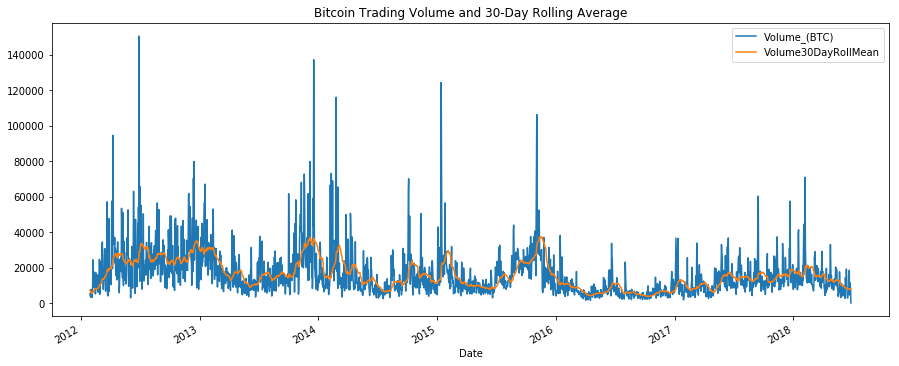

In [86]:
# Step 1.3.3d
# Plotting volume vs 30-day rolling average of volume

plt.figure(figsize=(16,6), facecolor='white')
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15,6))

df_rolling['Volume_(BTC)'].plot(legend=True)
df_rolling['Volume30DayRollMean'].plot(legend=True)
axis.set_title("Bitcoin Trading Volume and 30-Day Rolling Average, 2012-2018")

plt.savefig('volume_and_rolling_average.png', bbox_inches='tight')
    

<Figure size 720x2880 with 0 Axes>

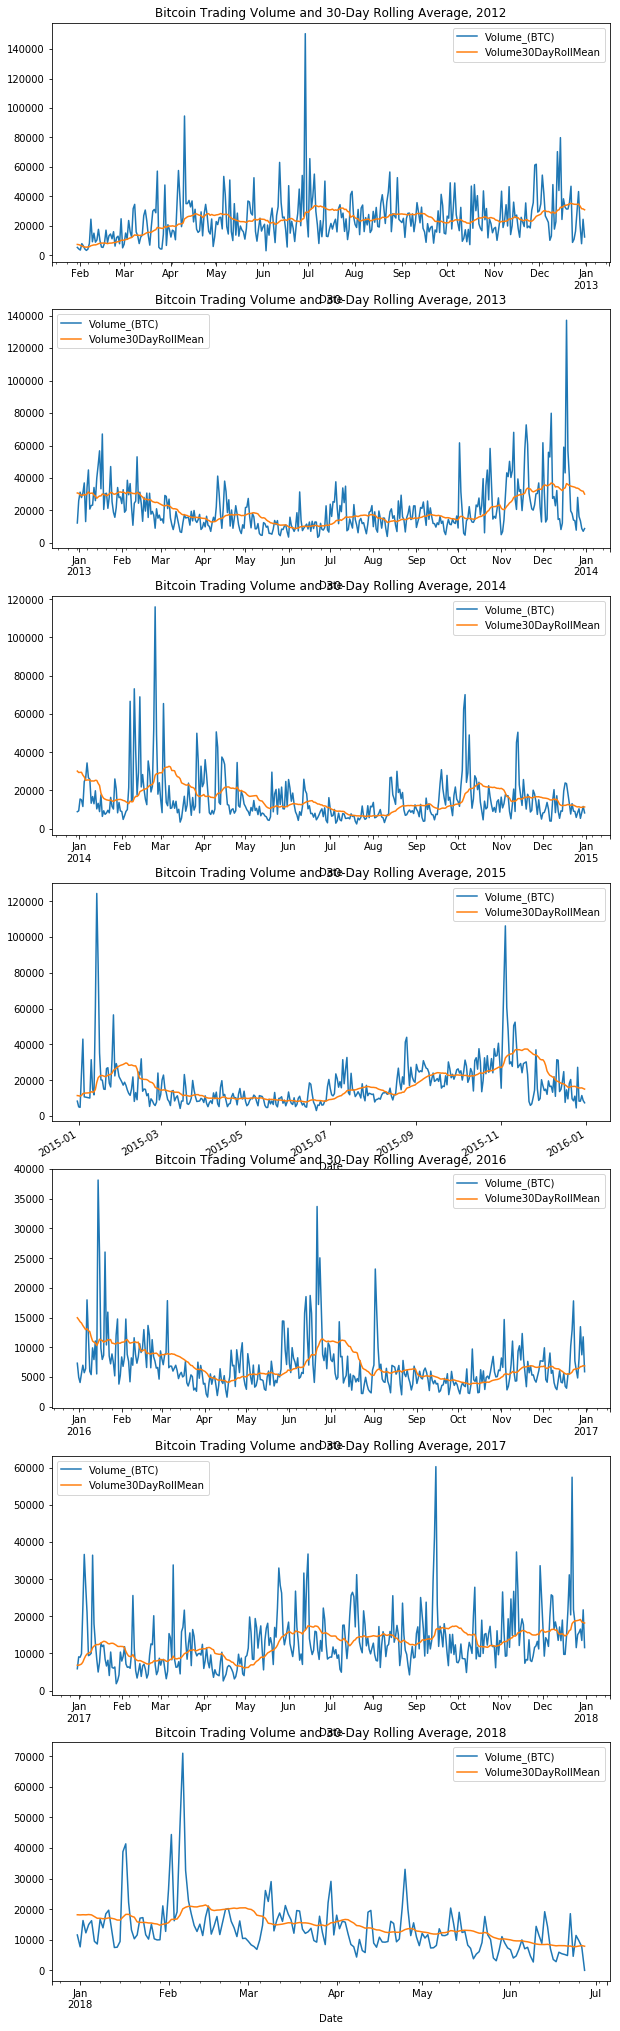

In [87]:
# Step 1.3.3e
# Plotting volume vs 30-Day rolling average of volume, zooming in on individual years

# http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
plt.figure(figsize=(10,40), facecolor='white')

plot_number = 0
fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for year in range(7):
    #print( str(years[year]) + " to " + str(years[year+1]) )
    df_rolling_yr = df_rolling.loc[years[year]:years[year+1]]
    ax = axes[plot_number]
    df_rolling_yr['Volume_(BTC)'].plot(ax = ax, legend=True)
    df_rolling_yr['Volume30DayRollMean'].plot(ax = ax, legend=True)
    ax.set_title("Bitcoin Trading Volume and 30-Day Rolling Average, " + years[year+1].strftime("%Y"))
    plot_number = plot_number + 1

plt.savefig('price_and_rolling_average.png', bbox_inches='tight')

<Figure size 1152x432 with 0 Axes>

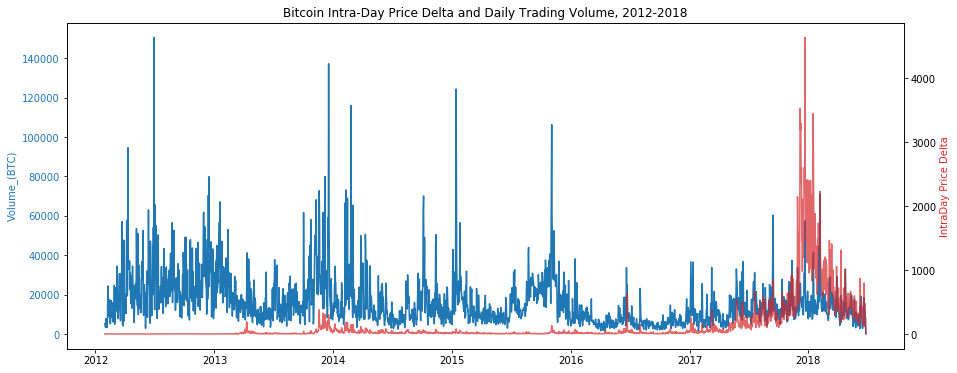

In [113]:
# Step 1.3.3f
# Plotting price intra-day deltas (high price minus low price for each day)

plt.figure(figsize=(16,6), facecolor='white')
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15,6))

color = 'tab:blue'
axis.set_ylabel('Volume_(BTC)', color=color) 
axis.plot(df_rolling['Volume_(BTC)'], color=color)
axis.tick_params(axis='y', labelcolor=color)

ax2 = axis.twinx()
color = 'tab:red'
ax2.set_ylabel('IntraDay Price Delta', color=color) 
ax2.plot(df_rolling['PriceIntraDayDelta'], color=color, alpha=0.7)
ax2.set_title("Bitcoin Intra-Day Price Delta and Daily Trading Volume, 2012-2018")



plt.savefig('volume_and_rolling_average.png', bbox_inches='tight')

<Figure size 720x2880 with 0 Axes>

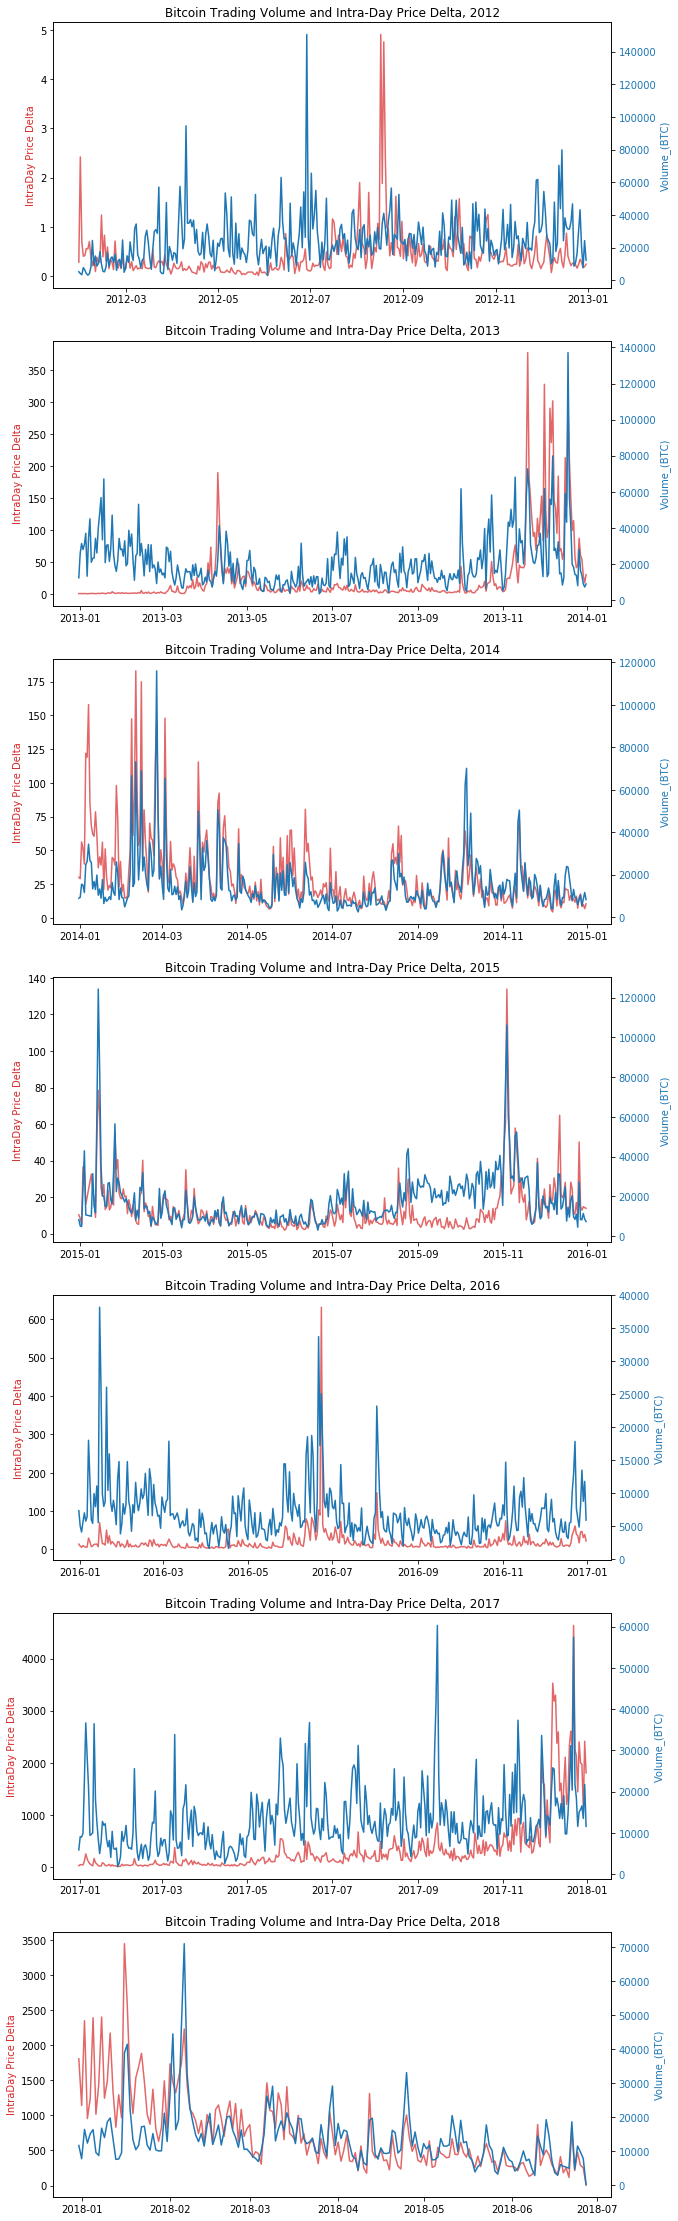

In [114]:
# Step 1.3.3g

plt.figure(figsize=(10,40), facecolor='white')

plot_number = 0
fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for year in range(7):
    #print( str(years[year]) + " to " + str(years[year+1]) )
    df_rolling_yr = df_rolling.loc[years[year]:years[year+1]]
    ax = axes[plot_number]
    ax2 = ax.twinx()
    
    ax.set_title("Bitcoin Trading Volume and Intra-Day Price Delta, " + years[year+1].strftime("%Y"))
    
    color = 'tab:red'
    ax.set_ylabel('IntraDay Price Delta', color=color) 
    ax.plot(df_rolling_yr['PriceIntraDayDelta'], color=color, alpha=0.7)
    
    color = 'tab:blue'
    ax2.set_ylabel('Volume_(BTC)', color=color) 
    ax2.plot(df_rolling_yr['Volume_(BTC)'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plot_number = plot_number + 1

plt.savefig('daily_intraday_price_delta_by_year.png', bbox_inches='tight')

#### Rolling standard deviations of price and volume

<Figure size 1152x432 with 0 Axes>

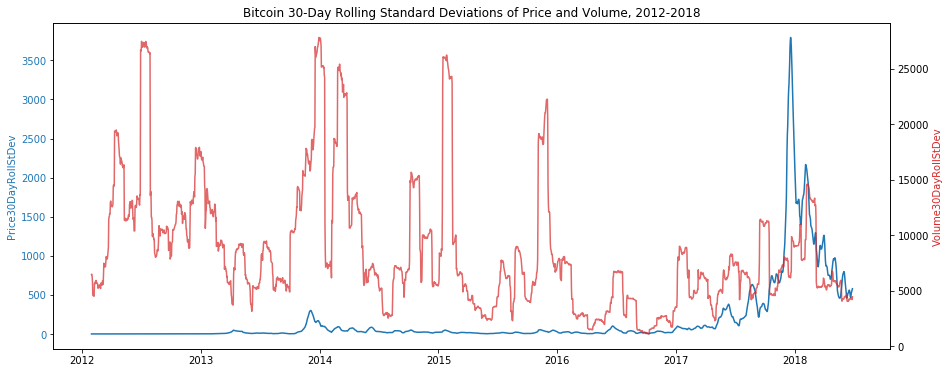

In [115]:
# Step 1.3.3h
#Price30DayRollStDev
#Volume30DayRollStDev
# Plotting rolling standard deviations of price and volume

plt.figure(figsize=(16,6), facecolor='white')
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15,6))

color = 'tab:blue'
axis.set_ylabel('Price30DayRollStDev', color=color) 
axis.plot(df_rolling['Price30DayRollStDev'], color=color)
axis.tick_params(axis='y', labelcolor=color)

ax2 = axis.twinx()
color = 'tab:red'
ax2.set_ylabel('Volume30DayRollStDev', color=color) 
ax2.plot(df_rolling['Volume30DayRollStDev'], color=color, alpha=0.7)
ax2.set_title("Bitcoin 30-Day Rolling Standard Deviations of Price and Volume, 2012-2018")



plt.savefig('price_and_volume_rolling_stdev.png', bbox_inches='tight')


<Figure size 720x2880 with 0 Axes>

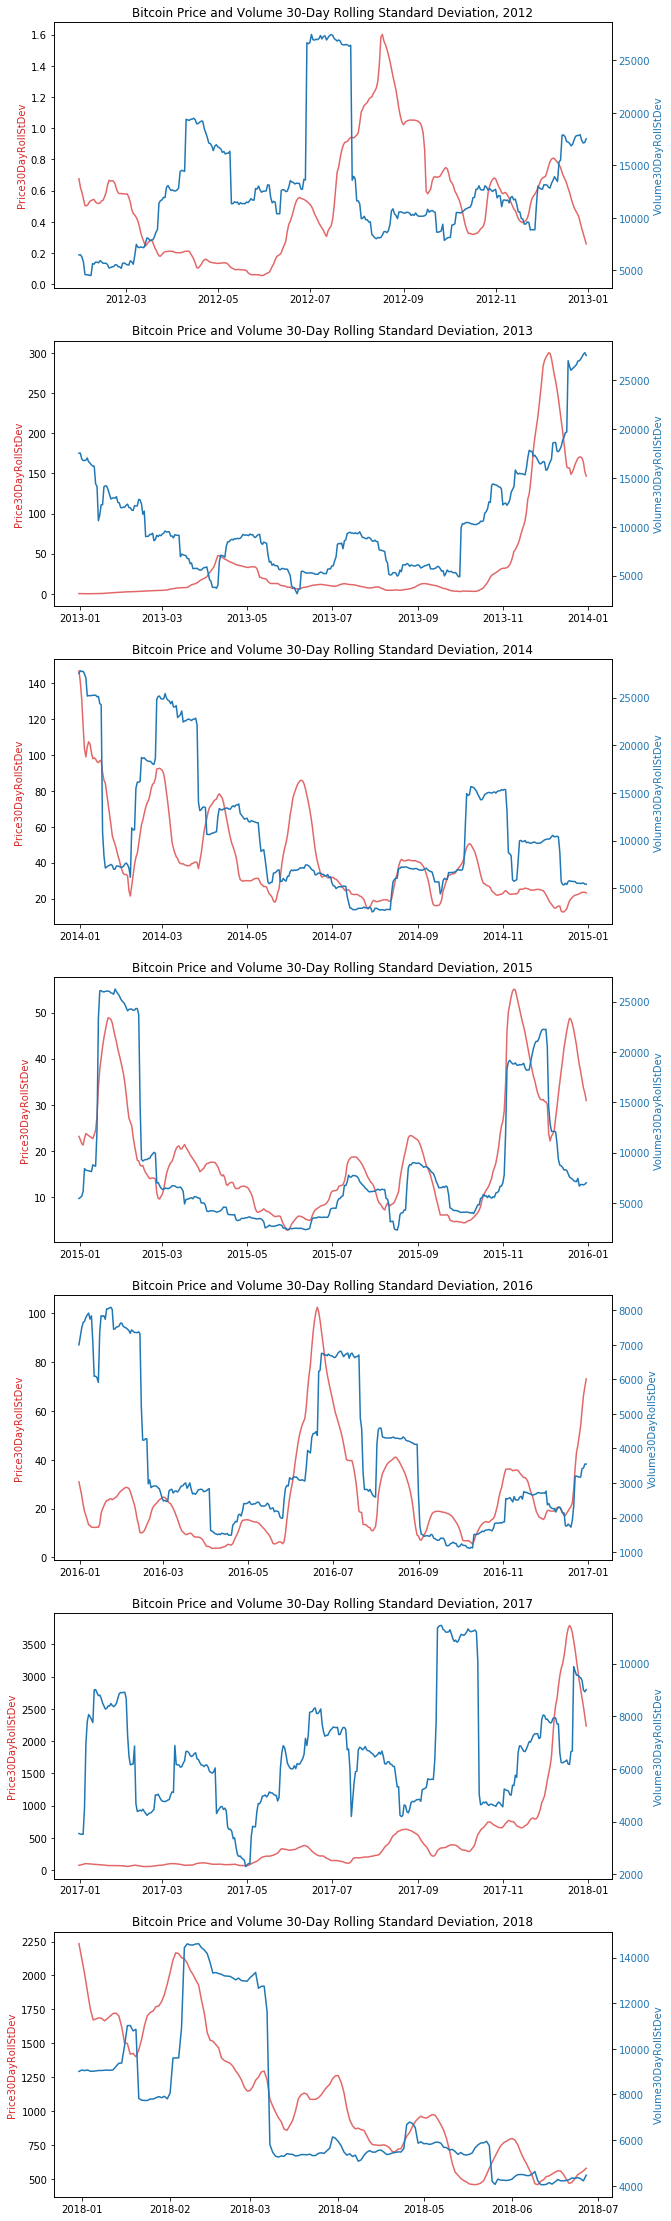

In [116]:
# Step 1.3.3i
#Price30DayRollStDev
#Volume30DayRollStDev
# Plotting rolling standard deviations of price and volume, zooming in on single years

plt.figure(figsize=(10,40), facecolor='white')

plot_number = 0
fig, axes = plt.subplots(nrows=sz, ncols=1, sharex=False, sharey=False, figsize=(10,40))

for year in range(7):
    #print( str(years[year]) + " to " + str(years[year+1]) )
    df_rolling_yr = df_rolling.loc[years[year]:years[year+1]]
    ax = axes[plot_number]
    ax2 = ax.twinx()
    
    ax.set_title("Bitcoin Price and Volume 30-Day Rolling Standard Deviations, " + years[year+1].strftime("%Y"))
    
    color = 'tab:red'
    ax.set_ylabel('Price30DayRollStDev', color=color) 
    ax.plot(df_rolling_yr['Price30DayRollStDev'], color=color, alpha=0.7)
    
    color = 'tab:blue'
    ax2.set_ylabel('Volume30DayRollStDev', color=color) 
    ax2.plot(df_rolling_yr['Volume30DayRollStDev'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plot_number = plot_number + 1

plt.savefig('rolling_stdev_price_and_volume_by_year.png', bbox_inches='tight')

# 2. Training
Place holder for description

## 2.1  RCF model with df_daily dataframe

In [117]:
# Step 2.1: create the random cut forest object, defining two parameters: num_samples_per_tree and num_trees.
# This will generate a model using the daily standard deviation dataframe

# I don't have the ability to write to Scott's S3 bucket, so I am writing to my own for now.

session = sagemaker.Session()
#bucket = 'ads-bucket-senichol'
#prefix = 'kaggle-crypto-data'
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=200,
                      num_trees=200)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_daily.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-13-04-22-08-430


2018-10-13 04:22:08 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-10-13 04:24:05 Downloading - Downloading input data...
2018-10-13 04:24:15 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[10/13/2018 04:24:37 INFO 139768447436608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/13/2018 04:24:37 INFO 139768447436608] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'28'


2018-10-13 04:24:41 Uploading - Uploading generated training model
2018-10-13 04:24:46 Completed - Training job completed
Billable seconds: 42


It takes a few minutes for the training instance to become available.

Don't worry about the output text above turning red. That's not an indication of an error.

You can view the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below.
https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs

If you see the message 

> `Billable seconds: nn`

at the end of the output in the box above, that means training successfully completed and the output RCF model was stored in the specified output path.

Building the model with the daily standard deviation data took about 5 minutes and 60 billable seconds.

In [118]:
# Step 2.1b: another reality check, confirming the name of the new training job. Not very helpful, atcually.
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2018-10-13-04-22-08-430


In [119]:
# Step 2.1c:  spin up endpoint instances for generating anamaly scores. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-13-04-35-16-296
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-13-04-22-08-430


---------------------------------------------------------------!

Building the endpoint also takes some time. 5 or 10 minutes.

You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below.  (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints)

In [120]:
# Step 2.1c: getting ready to send data to the endpoint so that it will spit out anomaly scores

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [121]:
# Step 2.1d: Here we take the original data and reformat it according to the format we just specified in step 10.
df_daily_numpy = df_daily.as_matrix()

In [122]:
# Step 2.1e: We generated anomaly scores for the daily std_dev records. let's look at them.

results = rcf_inference.predict(df_daily_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_daily['score'] = pd.Series(scores, index=df_daily.index)
df_daily['date'] = df_daily.index
df_daily.head()

,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,4.39,4.58,0.094181,4.472552,4.39,4.58,0.094229,4.472624,4.39,4.58,...,2.00000,210.720000,52.694724,34.069690,4.39,4.580000,0.094193,4.472579,1.661658,2011-12-31
2012-01-01,4.58,5.00,0.139856,4.680778,4.58,5.00,0.139856,4.680778,4.58,5.00,...,6.87916,50.500000,19.802958,27.856539,4.58,5.000000,0.139856,4.680778,1.697853,2012-01-01
2012-01-02,5.00,5.00,0.000000,5.000000,5.00,5.00,0.000000,5.000000,5.00,5.00,...,50.50000,95.240000,16.567370,57.832389,5.00,5.000000,0.000000,5.000000,1.699687,2012-01-02
2012-01-03,5.00,5.32,0.145733,5.145917,5.00,5.32,0.145733,5.145917,5.00,5.32,...,0.10280,155.010000,46.211054,68.725391,5.00,5.320000,0.145733,5.145917,1.667523,2012-01-03
2012-01-04,4.93,5.37,0.189487,5.176708,4.93,5.57,0.252133,5.228729,4.93,5.37,...,0.99000,235.747069,85.932931,91.624089,4.93,5.442972,0.210158,5.195443,1.657211,2012-01-04


In [123]:
df_daily.columns

Index(['Open_min', 'Open_max', 'Open_std', 'Open_mean', 'High_min', 'High_max',
       'High_std', 'High_mean', 'Low_min', 'Low_max', 'Low_std', 'Low_mean',
       'Close_min', 'Close_max', 'Close_std', 'Close_mean', 'Vol_BTC_min',
       'Vol_BTC_max', 'Vol_BTC_std', 'Vol_BTC_mean', 'Vol_Currency_min',
       'Vol_Currency_max', 'Vol_Currency_std', 'Vol_Currency_mean',
       'Wt_Price_min', 'Wt_Price_max', 'Wt_Price_std', 'Wt_Price_mean',
       'score', 'date'],
      dtype='object')

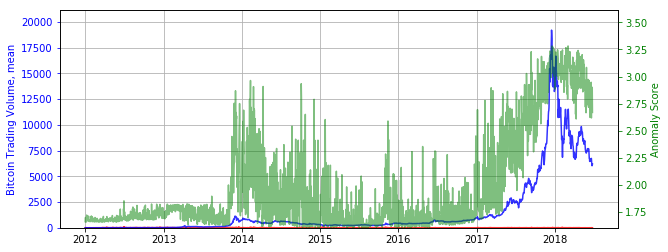

In [124]:
# Step 2.1f: Plot the anomaly scores along with some features from the daily std_dev data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_daily['Vol_BTC_mean'], color='r', alpha=0.8)
ax1.plot(df_daily['High_mean'], color='b', alpha=0.8)
ax2.plot(df_daily['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, mean', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.1*df_daily['High_mean'].max())
ax2.set_ylim(df_daily['score'].min(), 1.1*df_daily['score'].max())
fig.set_figwidth(10)


In [125]:
# Step 2.1g: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_daily['score'].mean()
score_std = df_daily['score'].std()
score_cutoff = score_mean + 2*score_std
print("Score mean:" + str(score_mean) + ", Score std: " + str(score_std) + "Score cutoff:" + str(score_cutoff))
anomalies = df_daily[df_daily['score'] > score_cutoff]
print("At a 3 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

Score mean:1.97558983336967, Score std: 0.4561671405807226Score cutoff:2.887924114531115
At a 3 sd threshhold, there are 203 anomalies.


,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-10,535.30,709.90,24.851997,673.042396,535.31,713.00,24.078926,674.580819,530.00,703.47,...,5.250774,1.865889e+06,94768.151304,32476.952005,533.932106,708.953440,24.802235,673.132713,2.963216,2014-02-10
2014-02-24,520.00,614.84,17.260934,568.126479,534.00,629.00,17.147607,568.881576,514.02,611.52,...,2.764945,1.659301e+06,69139.908124,20481.230439,522.883099,618.654581,17.318245,567.900690,2.906722,2014-02-24
2014-04-10,357.57,442.46,17.718233,408.493917,360.00,442.46,17.407173,409.333083,357.57,442.46,...,0.999998,1.666193e+06,62229.951461,14026.139859,358.124877,442.460000,17.695231,408.518630,2.908050,2014-04-10
2014-10-05,277.97,338.90,14.449493,315.704250,278.17,339.43,14.304777,316.283924,275.00,338.70,...,5.492846,1.761476e+06,54618.684666,13290.427019,276.258759,339.005264,14.555745,315.678048,2.933737,2014-10-05
2017-03-10,983.00,1329.66,49.346348,1202.469681,1009.92,1350.00,48.877499,1203.985424,975.00,1312.03,...,4.186206,1.605414e+06,97519.963849,27271.946827,993.412590,1338.026120,49.640416,1202.407481,2.896181,2017-03-10


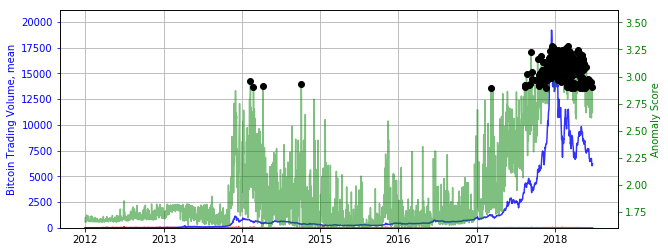

In [126]:
# Step 2.1h: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
# high anomaly scores are highly concentrated around the end of 2017/beginning of 2018.

In [127]:
top_anomaly = df_daily.sort_values('score', ascending=False).head(200)

In [129]:
# step 2.1i: top_anomalies for df_daily

In [130]:
# step 2.1j: Save anomaly result to S3
prefix_result_folder = 'group-project/bitcoin'
result_filename = 'top_200_daily_anomalies_with_dates.csv'

top_anomaly.to_csv(result_filename, index=True, header=True)

s3 = boto3.client(
    's3'
 #   aws_access_key_id = access_key_id,
 #   aws_secret_access_key= secret_access_key,
)

# Upload the file to S3
with open(result_filename, 'rb') as data:
    s3.upload_fileobj(data, bucket, Key=f'{prefix_result_folder}/{result_filename}')

In [131]:
# step 2.1k
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-13-04-22-08-430


In [132]:
# step 2.1l
top_anom_df = pd.read_csv('top_anomaly.csv', encoding="ISO-8859-1", low_memory=False)

#minute_df = pd.read_csv('~/SageMaker/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

top_anom_df.columns

Index(['Date', 'Open_min', 'Open_max', 'Open_std', 'Open_mean', 'High_min',
       'High_max', 'High_std', 'High_mean', 'Low_min', 'Low_max', 'Low_std',
       'Low_mean', 'Close_min', 'Close_max', 'Close_std', 'Close_mean',
       'Vol_BTC_min', 'Vol_BTC_max', 'Vol_BTC_std', 'Vol_BTC_mean',
       'Vol_Currency_min', 'Vol_Currency_max', 'Vol_Currency_std',
       'Vol_Currency_mean', 'Wt_Price_min', 'Wt_Price_max', 'Wt_Price_std',
       'Wt_Price_mean', 'score', 'date'],
      dtype='object')

In [133]:
# step 2.1m
top_anomaly.to_csv('top_anomaly.csv', header=True)

## 2.2 RCF modelling with the df_deltas datraframe

In [134]:
#step 2.2a: data cleaning for percentage deltas model

# removing nas and inf values in the delta features. 
#df_deltas.loc[:,['Volume_(BTC)_delta_1', 'Volume_(BTC)_delta_30', 'Volume_(BTC)_delta_60']] = df_deltas.loc[:, ['Volume_(BTC)_delta_1', 'Volume_(BTC)_delta_30', 'Volume_(BTC)_delta_60']].replace(np.inf, np.nan)
#df_deltas = df_deltas.dropna(how="any")

# Remove unneeded time attributes
df_daily_deltas = df_deltas[df_deltas.columns.difference(["Minute", "Hour"])]
print(df_daily_deltas.columns)

# Group all emaining delta values by Date
df_daily_deltas = df_daily_deltas.groupby(['Date']).agg(['min', 'max', 'std','mean'])

# renaming columns
df_daily_deltas.columns = [ 'Close_delta_1_min', 'Close_delta_1_max', 'Close_delta_1_std', 'Close_delta_1_mean',
                            'Close_delta_30_min', 'Close_delta_30_max', 'Close_delta_30_std', 'Close_delta_30_mean',
                            'Close_delta_60_min', 'Close_delta_60_max', 'Close_delta_60_std', 'Close_delta_60_mean',
                            'High_delta_1_min', 'High_delta_1_max', 'High_delta_1_std', 'High_delta_1_mean',
                            'High_delta_30_min', 'High_delta_30_max', 'High_delta_30_std', 'High_delta_30_mean',
                            'High_delta_60_min', 'High_delta_60_max', 'High_delta_60_std', 'High_delta_60_mean',
                            'Low_delta_1_min', 'Low_delta_1_max', 'Low_delta_1_std', 'Low_delta_1_mean',
                            'Low_delta_30_min', 'Low_delta_30_max', 'Low_delta_30_std', 'Low_delta_30_mean',
                            'Low_delta_60_min', 'Low_delta_60_max', 'Low_delta_60_std', 'Low_delta_60_mean',
                            'Open_delta_1_min', 'Open_delta_1_max', 'Open_delta_1_std', 'Open_delta_1_mean',
                            'Open_delta_30_min', 'Open_delta_30_max', 'Open_delta_30_std', 'Open_delta_30_mean',
                            'Open_delta_60_min', 'Open_delta_60_max', 'Open_delta_60_std', 'Open_delta_60_mean',
                            'Volume_(BTC)_delta_1_min', 'Volume_(BTC)_delta_1_max', 'Volume_(BTC)_delta_1_std', 'Volume_(BTC)_delta_1_mean',
                            'Volume_(BTC)_delta_30_min', 'Volume_(BTC)_delta_30_max', 'Volume_(BTC)_delta_30_std', 'Volume_(BTC)_delta_30_mean',
                            'Volume_(BTC)_delta_60_min', 'Volume_(BTC)_delta_60_max', 'Volume_(BTC)_delta_60_std', 'Volume_(BTC)_delta_60_mean',
                            'Weighted_Price_delta_1_min', 'Weighted_Price_delta_1_max', 'Weighted_Price_delta_1_std', 'Weighted_Price_delta_1_mean',
                            'Weighted_Price_delta_30_min', 'Weighted_Price_delta_30_max', 'Weighted_Price_delta_30_std', 'Weighted_Price_delta_30_mean',
                            'Weighted_Price_delta_60_min', 'Weighted_Price_delta_60_max', 'Weighted_Price_delta_60_std', 'Weighted_Price_delta_60_mean']

#drop any nas that were created during the groupby operation
df_daily_deltas = df_daily_deltas.dropna(how='any')


Index(['Close_delta_1', 'Close_delta_30', 'Close_delta_60', 'Date',
       'High_delta_1', 'High_delta_30', 'High_delta_60', 'Low_delta_1',
       'Low_delta_30', 'Low_delta_60', 'Open_delta_1', 'Open_delta_30',
       'Open_delta_60', 'Volume_(BTC)_delta_1', 'Volume_(BTC)_delta_30',
       'Volume_(BTC)_delta_60', 'Weighted_Price_delta_1',
       'Weighted_Price_delta_30', 'Weighted_Price_delta_60'],
      dtype='object')


In [142]:
#step 2.2b:  building RCF training job for percentage_deltas model.

session = sagemaker.Session()
bucket = 'sagemaker-davidrob'
prefix = 'group-project/bitcoin'
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=100,
                      num_trees=100)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_daily_deltas.values))

ValueError: Unsupported dtype object on array

In [136]:
# step 2.2c:  spin up endpoint instances for generating anamaly scores for percentage deltas model. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-13-04-49-36-847
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-13-04-45-18-391


----------------------------------------------------------------!

In [137]:
# step 2.2d: getting ready to send data to the endpoint so that it will spit out anomaly scores

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [138]:
# step 2.2e: convert our deltas dataframe to an appropriate matrix format for predicting
df_daily_deltas_numpy = df_daily_deltas.as_matrix()

results = rcf_inference.predict(df_daily_deltas_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_daily_deltas['score'] = pd.Series(scores, index=df_daily_deltas.index)
df_daily_deltas['date'] = df_daily_deltas.index
df_daily_deltas.head()

,Close_delta_1_min,Close_delta_1_max,Close_delta_1_std,Close_delta_1_mean,Close_delta_30_min,Close_delta_30_max,Close_delta_30_std,Close_delta_30_mean,Close_delta_60_min,Close_delta_60_max,...,Weighted_Price_delta_30_min,Weighted_Price_delta_30_max,Weighted_Price_delta_30_std,Weighted_Price_delta_30_mean,Weighted_Price_delta_60_min,Weighted_Price_delta_60_max,Weighted_Price_delta_60_std,Weighted_Price_delta_60_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,0.000000,0.041002,0.001980,0.000100,0.000000,0.043280,0.011019,0.003019,0.000000,0.043280,...,0.000000,0.043280,0.010958,0.003019,0.000000,0.043280,0.014955,0.006038,1.559114,2011-12-31
2012-01-01,0.000000,0.056769,0.001731,0.000062,0.000000,0.056769,0.009299,0.001871,0.000000,0.056769,...,0.000000,0.056769,0.009299,0.001871,0.000000,0.056769,0.012881,0.003743,1.471727,2012-01-01
2012-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.557425,2012-01-02
2012-01-03,-0.011278,0.064000,0.001746,0.000042,-0.011278,0.064000,0.009484,0.001256,-0.011278,0.064000,...,-0.011278,0.064000,0.009484,0.001256,-0.011278,0.064000,0.013218,0.002510,1.392706,2012-01-03
2012-01-04,-0.068053,0.052738,0.002572,0.000039,-0.068053,0.052738,0.014327,0.001179,-0.068053,0.052738,...,-0.068053,0.052738,0.013416,0.000686,-0.068053,0.052738,0.018991,0.001372,1.506911,2012-01-04


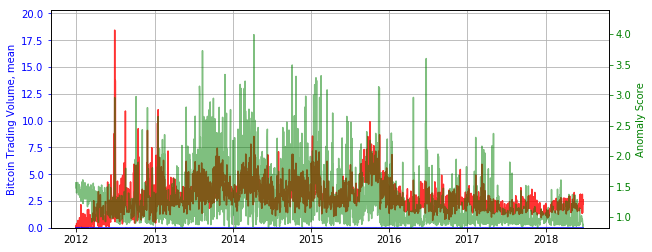

In [139]:
# step 2.2f: Plot the anomaly scores along with some features from the daily std_dev data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_daily_deltas['Volume_(BTC)_delta_60_mean'], color='r', alpha=0.8)
ax1.plot(df_daily_deltas['High_delta_60_mean'], color='b', alpha=0.8)
ax2.plot(df_daily_deltas['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, mean', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.1*df_daily_deltas['Volume_(BTC)_delta_60_mean'].max())
ax2.set_ylim(df_daily_deltas['score'].min(), 1.1*df_daily_deltas['score'].max())
fig.set_figwidth(10)
plt.show()

In [143]:
# step 2.2g: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_daily_deltas['score'].mean()
score_std = df_daily_deltas['score'].std()
score_cutoff = score_mean + 3*score_std
print("Score mean:" + str(score_mean) + ", Score std: " + str(score_std) + "Score cutoff:" + str(score_cutoff))
anomalies = df_daily_deltas[df_daily_deltas['score'] > score_cutoff]
print("At a 3.0 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.score

Score mean:1.255437824199621, Score std: 0.44832669582861046Score cutoff:2.600417911685452
At a 3.5 sd threshhold, there are 51 anomalies.


Date
2012-06-29    2.957650
2012-10-07    2.975224
2012-11-29    2.793154
2013-01-18    2.646773
2013-05-29    2.801757
2013-07-08    2.623140
2013-07-10    2.653038
2013-07-30    3.145629
2013-07-31    3.012854
2013-08-13    3.728017
2013-08-15    2.611622
2013-08-19    2.646584
2013-09-05    2.649840
2013-09-12    2.756276
2013-09-18    2.886780
2013-09-27    2.643083
2013-10-03    2.947088
2013-10-10    2.610296
2013-10-30    2.798525
2013-11-15    2.634734
2013-11-26    3.337088
2013-12-03    2.700412
2013-12-22    2.760903
2014-02-05    3.174543
2014-02-09    3.109465
2014-02-24    3.109514
2014-02-28    3.228355
2014-03-02    2.739054
2014-03-18    2.768379
2014-03-21    2.622814
2014-03-31    2.718697
2014-04-10    3.991000
2014-10-06    3.492915
2014-10-16    2.659424
2014-10-24    3.306648
2014-12-04    2.801248
2014-12-08    2.981683
2015-01-14    2.998329
2015-01-19    3.170845
2015-01-22    2.708000
2015-01-25    3.283460
2015-01-28    3.237002
2015-02-11    2.961259
2015-0

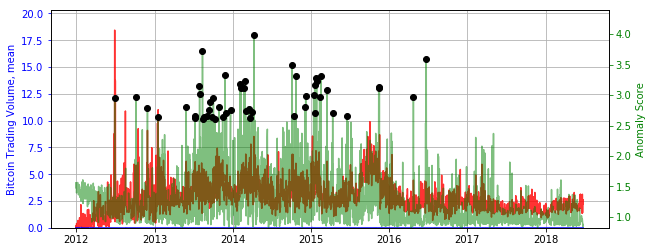

In [144]:
# step 2.2h: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
# high anomaly scores are highly concentrated around the end of 2017/beginning of 2018.

In [145]:
# step 2.2i:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-13-04-45-18-391


In [146]:
# step 2.2j: create an anomaly indicator columns
df_daily_deltas['anomalies'] = (df_daily_deltas['score'] > score_cutoff)
# write dataframe to csv locally
df_daily_deltas.to_csv('df_daily_deltas_with_scores_volume_greater_than_1.csv', index=True, header=True)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


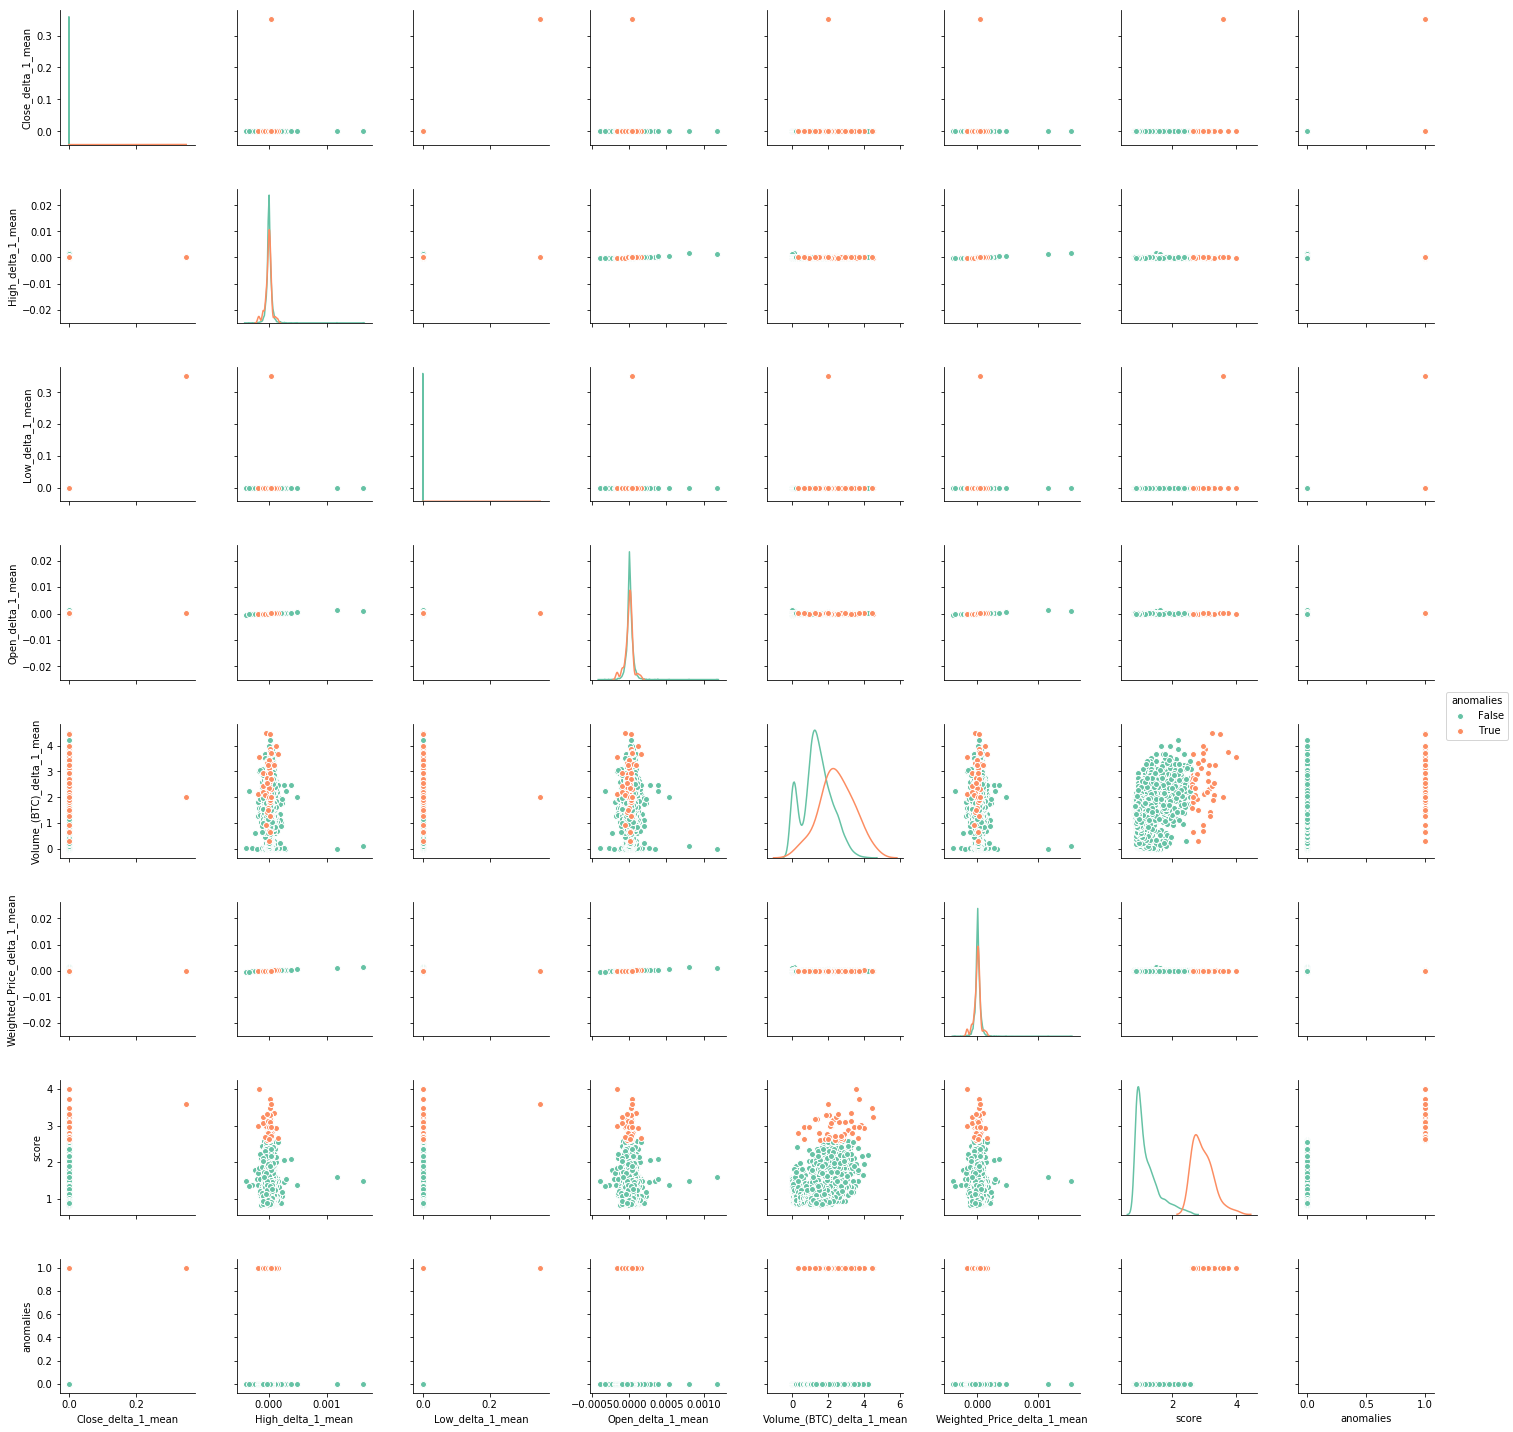

In [147]:
#step 2.2k:  produce a pairwise plot of features. there is a step below that selects a set of feature columns based on a regex search through the column names.
# this can be very slow when including too many features.

sixty_cols = df_daily_deltas.columns.str.contains('1_mean', regex=True) # pulls in all attributes with column names matching the pattern in contains()
sixty_cols[72:73] = True # pulls in score attribute
sixty_cols[74:75] = True # pulls in anomaly attribute
sixty_cols
g = sns.pairplot(df_daily_deltas.iloc[:, sixty_cols], hue="anomalies", palette="Set2", diag_kind="kde")
plt.show()

## 2.3  RCF Modeling with df_rolling dataframe

In [148]:
#step 2.3a:  building RCF training job for percentage_deltas model.

session = sagemaker.Session()
bucket = 'sagemaker-davidrob'
prefix = 'group-project/bitcoin'
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=200,
                      num_trees=200)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_rolling.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-13-05-00-00-718


2018-10-13 05:00:00 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-10-13 05:01:54 Downloading - Downloading input data...
2018-10-13 05:02:05 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[10/13/2018 05:02:30 INFO 140280674506560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/13/2018 05:02:30 INFO 140280674506560] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'10'


2018-10-13 05:02:35 Uploading - Uploading generated training model
2018-10-13 05:02:41 Completed - Training job completed
Billable seconds: 47


In [ ]:
# step 2.3b:  spin up endpoint instances for generating anamaly scores for percentage deltas model. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-13-05-03-43-574
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-13-05-00-00-718


-------------------------------

In [ ]:
# step 2.3c: getting ready to send data to the endpoint so that it will spit out anomaly scores

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [ ]:
# step 2.3d: convert our deltas dataframe to an appropriate matrix format for predicting
df_rolling_numpy = df_rolling.as_matrix()

results = rcf_inference.predict(df_rolling_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_rolling['score'] = pd.Series(scores, index=df_rolling.index)
df_rolling['date'] = df_rolling.index
df_rolling.head()

In [ ]:
# step 2.3e: Plot the anomaly scores along with some features from the daily std_dev data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_rolling['Volume_(BTC)'], color='r', alpha=0.8)
ax1.plot(df_rolling['Weighted_Price'], color='b', alpha=0.8)
ax2.plot(df_rolling['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.1*df_rolling['Volume_(BTC)'].max())
ax2.set_ylim(df_rolling['score'].min(), 1.1*df_rolling['score'].max())
fig.set_figwidth(10)
plt.show()

In [ ]:
# step 2.3f: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_rolling['score'].mean()
score_std = df_rolling['score'].std()
score_cutoff = score_mean + 3*score_std
print("Score mean:" + str(score_mean) + ", Score std: " + str(score_std) + "Score cutoff:" + str(score_cutoff))
anomalies = df_rolling[df_rolling['score'] > score_cutoff]
print("At a 3.0 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.score

In [ ]:
# step 2.3g: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [ ]:
# step 2.3h: sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

In [ ]:
# step 2.3i: create an anomaly indicator columns
df_daily_deltas['anomalies'] = (df_daily_deltas['score'] > score_cutoff)
# write dataframe to csv locally
df_daily_deltas.to_csv('df_daily_deltas_with_scores_volume_greater_than_1.csv', index=True, header=True)

In [ ]:
#step 2.3j:  another visualization of the df_rolling anomlaies?

### Summary
Place holder for description